In [1]:
import pickle
import numpy as np

msa_files = [
    "./pfam_msa/aa_index.pkl",
    "./pfam_msa/seq_pos_idx.pkl",
    "./pfam_msa/seq_msa.pkl",
    "./pfam_msa/seq_msa_binary.pkl",
    "./pfam_msa/seq_weight.pkl"
]

# Read in each file and store it in a separate variable
with open("./pfam_msa/aa_index.pkl", 'rb') as file:
    aa_index = pickle.load(file)

with open("./pfam_msa/seq_pos_idx.pkl", 'rb') as file:
    seq_pos_idx = pickle.load(file)

with open("./pfam_msa/seq_msa.pkl", 'rb') as file:
    seq_msa = pickle.load(file)

with open("./pfam_msa/seq_msa_binary.pkl", 'rb') as file:
    seq_msa_binary = pickle.load(file)

with open("./pfam_msa/seq_weight.pkl", 'rb') as file:
    seq_weight = pickle.load(file)

# Print information about each loaded variable
print(f"aa_index: {type(aa_index)}, {'length: ' + str(len(aa_index)) if isinstance(aa_index, (dict, list)) else 'shape: ' + str(aa_index.shape) if isinstance(aa_index, np.ndarray) else ''}")
print(f"seq_pos_idx: {type(seq_pos_idx)}, {'length: ' + str(len(seq_pos_idx)) if isinstance(seq_pos_idx, (dict, list)) else 'shape: ' + str(seq_pos_idx.shape) if isinstance(seq_pos_idx, np.ndarray) else ''}")
print(f"seq_msa: {type(seq_msa)}, {'length: ' + str(len(seq_msa)) if isinstance(seq_msa, (dict, list)) else 'shape: ' + str(seq_msa.shape) if isinstance(seq_msa, np.ndarray) else ''}")
print(f"seq_msa_binary: {type(seq_msa_binary)}, {'length: ' + str(len(seq_msa_binary)) if isinstance(seq_msa_binary, (dict, list)) else 'shape: ' + str(seq_msa_binary.shape) if isinstance(seq_msa_binary, np.ndarray) else ''}")
print(f"seq_weight: {type(seq_weight)}, {'length: ' + str(len(seq_weight)) if isinstance(seq_weight, (dict, list)) else 'shape: ' + str(seq_weight.shape) if isinstance(seq_weight, np.ndarray) else ''}")


aa_index: <class 'dict'>, length: 25
seq_pos_idx: <class 'list'>, length: 75
seq_msa: <class 'numpy.ndarray'>, shape: (667693, 75)
seq_msa_binary: <class 'numpy.ndarray'>, shape: (667693, 75, 21)
seq_weight: <class 'numpy.ndarray'>, shape: (667693,)


In [2]:
import pickle

# Path to the model .pkl file
model_file_path = "./model/model_weight_decay_0.050.pkl"

# Open the .pkl file in binary read mode
with open(model_file_path, 'rb') as file:
    # Load the content of the file
    model = pickle.load(file)

# Print the keys in the model dictionary
print("Keys in the model dictionary:")
for key in model.keys():
    print(key)

Keys in the model dictionary:
len_seq
K
num_node
weight_decay
max_iter
J
h


In [3]:
# Print out the shapes of J and h
print("Shape of J:", model['J'].shape)
print("Shape of h:", model['h'].shape)

# Optionally, you can also print out some additional information
print("Length of sequence (len_seq):", model['len_seq'])
print("Number of amino acid types (K):", model['K'])
print("Number of nodes (num_node):", model['num_node'])


Shape of J: (1575, 1575)
Shape of h: (1575,)
Length of sequence (len_seq): 75
Number of amino acid types (K): 21
Number of nodes (num_node): 1575


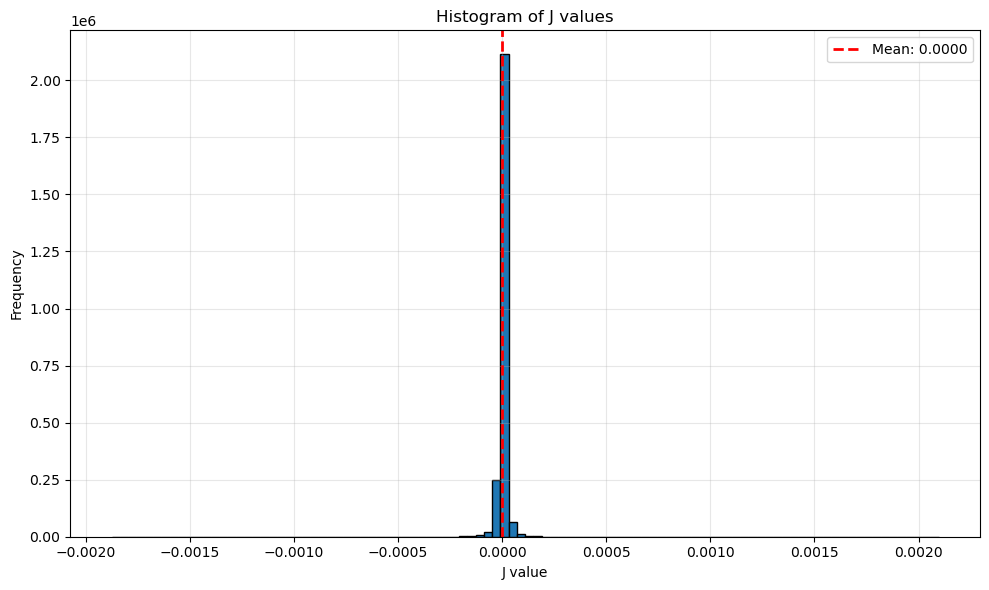

Number of J values: 2480625
Mean of J values: 0.0000
Standard deviation of J values: 0.0000
Min J value: -0.0019
Max J value: 0.0021


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Extract J values from the model
J_values = model['J'].flatten()

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(J_values, bins=100, edgecolor='black')
plt.title('Histogram of J values')
plt.xlabel('J value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add vertical line at mean
mean_J = np.mean(J_values)
plt.axvline(mean_J, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_J:.4f}')

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Number of J values: {len(J_values)}")
print(f"Mean of J values: {mean_J:.4f}")
print(f"Standard deviation of J values: {np.std(J_values):.4f}")
print(f"Min J value: {np.min(J_values):.4f}")
print(f"Max J value: {np.max(J_values):.4f}")


In [5]:
import numpy as np
import pickle

# Load the model
model_file = "./model/model_weight_decay_0.050.pkl"  # Replace with the path to your model file
with open(model_file, 'rb') as file:
    model = pickle.load(file)

# Extract parameters from the model
J = model['J']
len_seq = model['len_seq']
K = model['K']

# Calculate interaction scores
J_prime_dict = {}
score_FN = np.zeros([len_seq, len_seq])
for i in range(len_seq):
    for j in range(i + 1, len_seq):
        J_prime = J[(i * K):(i * K + K), (j * K):(j * K + K)]
        J_prime = J_prime - J_prime.mean(0).reshape([1, -1]) - J_prime.mean(1).reshape([-1, 1]) + J_prime.mean()
        J_prime_dict[(i, j)] = J_prime
        score_FN[i, j] = np.sqrt(np.sum(J_prime * J_prime))
        score_FN[j, i] = score_FN[i, j]

# Normalize the scores
score_CN = score_FN - score_FN.mean(1).reshape([-1, 1]).dot(score_FN.mean(0).reshape([1, -1])) / np.mean(score_FN)

# Apply distance constraint
for i in range(score_CN.shape[0]):
    for j in range(score_CN.shape[1]):
        if abs(i - j) <= 4:
            score_CN[i, j] = -np.inf

# Print the resulting score_CN matrix
print(score_CN.shape)

(75, 75)


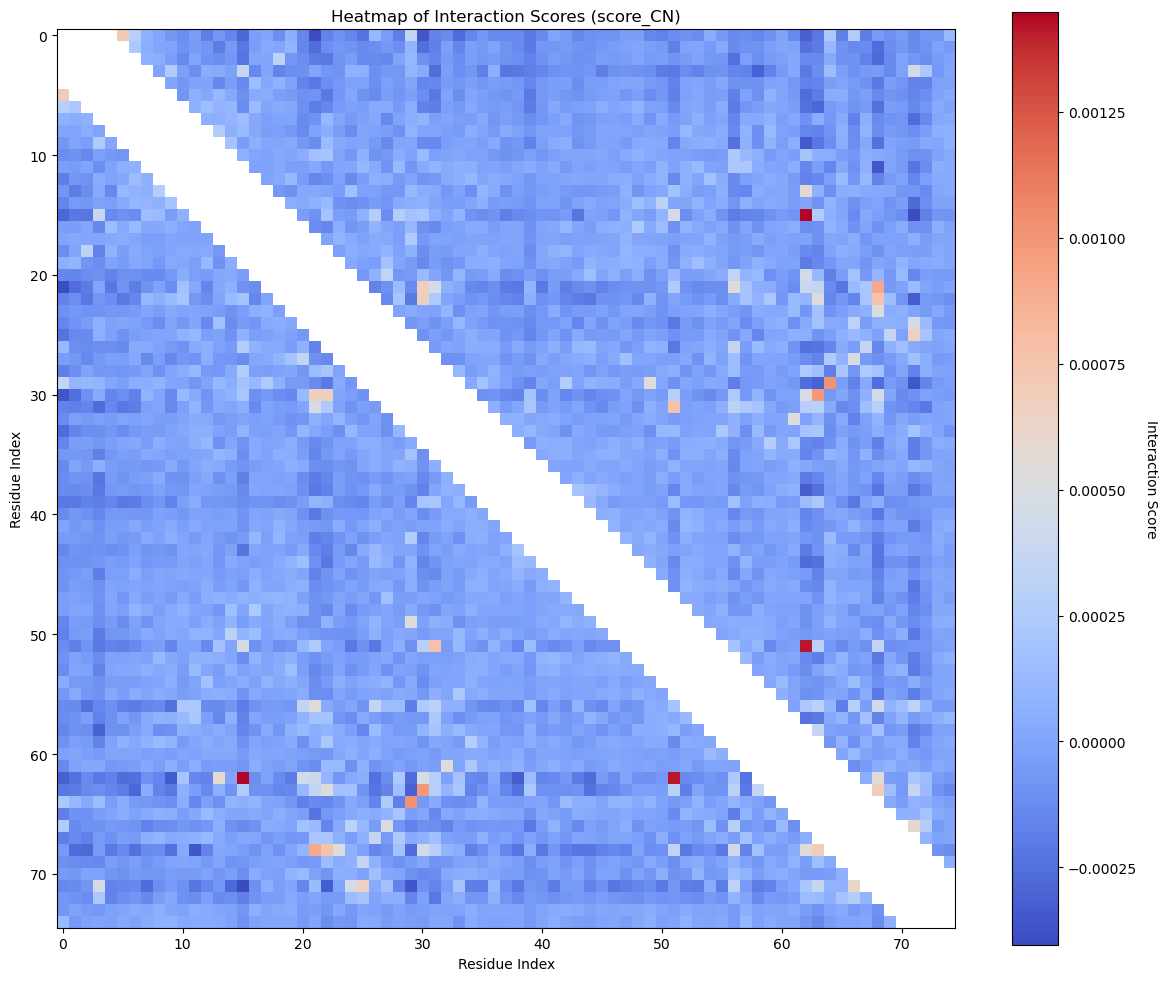

Shape of score_CN matrix: (75, 75)
Minimum finite score: -0.0004
Maximum score: 0.0014
Mean of finite scores: -0.0000


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the score_CN matrix
plt.figure(figsize=(12, 10))
heatmap = plt.imshow(score_CN, cmap='coolwarm', vmin=np.min(score_CN[np.isfinite(score_CN)]), vmax=np.max(score_CN))

plt.title('Heatmap of Interaction Scores (score_CN)')
plt.xlabel('Residue Index')
plt.ylabel('Residue Index')

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label('Interaction Score', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Print some statistics about the score_CN matrix
print(f"Shape of score_CN matrix: {score_CN.shape}")
print(f"Minimum finite score: {np.min(score_CN[np.isfinite(score_CN)]):.4f}")
print(f"Maximum score: {np.max(score_CN):.4f}")
print(f"Mean of finite scores: {np.mean(score_CN[np.isfinite(score_CN)]):.4f}")


In [8]:
from Bio import PDB
def process_pdb(pdb_file, chain_id, start, end, output_file):
    parser = PDB.PDBParser()
    structure = parser.get_structure('AF', pdb_file)
    
    # Create a new structure to hold the selected residues
    new_structure = PDB.Structure.Structure('processed')
    new_model = PDB.Model.Model(0)
    new_chain = PDB.Chain.Chain(chain_id)
    
    for model in structure:
        for chain in model:
            if chain.id == chain_id:
                for residue in chain:
                    if start <= residue.id[1] <= end:
                        new_chain.add(residue.copy())
    
    new_model.add(new_chain)
    new_structure.add(new_model)

    # Save the new structure as a PDB file
    io = PDB.PDBIO()
    io.set_structure(new_structure)
    io.save(output_file)

    print(f"Processed structure saved to {output_file}")

# Example usage
pdb_file = "./pdb/AF-A0A7K4UZQ6-F1-model_v4.pdb"
chain_id = "A"  # Replace with the actual chain ID if different
start = 901
end = 989
output_file = "./pdb/processed_structure.pdb"  # Add output file name
process_pdb(pdb_file, chain_id, start, end, output_file)

Processed structure saved to ./pdb/processed_structure.pdb


In [9]:
from Bio import PDB
import numpy as np

def calculate_distance(atom1, atom2):
    """Calculate the Euclidean distance between two atoms."""
    diff_vector = atom1.coord - atom2.coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def process_pdb(pdb_file, output_file):
    parser = PDB.PDBParser()
    structure = parser.get_structure('PDB', pdb_file)
    
    # Assuming we are interested in the first model and chain
    model = structure[0]
    chain = model.child_list[0]  # Get the first chain
    
    residues = list(chain)
    
    with open(output_file, 'w') as f:
        for i in range(len(residues)):
            for j in range(i + 1, len(residues)):
                res1 = residues[i]
                res2 = residues[j]
                
                try:
                    # Calculate the distance between the CA atoms of the residues
                    distance = calculate_distance(res1['CA'], res2['CA'])
                    
                    # Write the result to the output file
                    f.write(f"{res1.id[1]},{res2.id[1]},{distance}\n")
                except KeyError:
                    print(f"CA atom not found in residue {res1.id[1]} or {res2.id[1]}")
# Example usage
pdb_file = "./pdb/processed_structure.pdb"  # Replace with the path to your PDB file
output_file = "./pdb/dist_pdb.txt"
process_pdb(pdb_file, output_file)